In [151]:
import pandas as pd
import os
import ast
import numpy as np
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.2f}'.format

In [3]:
all_results = []
for f in os.listdir('.'):
    if '.data' in f:
        with open(f, 'r') as g:
            all_results.append(ast.literal_eval(g.read()))

In [4]:
def standardize_to_uM(concentration, unit, sequence):
    concentration = concentration.replace(' ', '')
    try:
        concentration = float(concentration)
    except:
        return None
    if unit == 'uM' or unit == u'\xb5M' or unit == u'uM)':
        return concentration
    elif unit == 'ug/ml' or unit == u'\xb5g/ml' or unit == u'ug/ml)':
        try:
            molWt = ProteinAnalysis(sequence).molecular_weight()
        except ValueError:
            return None
        return concentration * 1000/molWt
    elif unit == 'nmol/g' or unit == 'pmol/mg':
        #1g, at density of 1g/mL, is 1mL, so nmol/g is nmol/mL = umol/L = uM yay!
        return concentration
    else:
        # print 'Unit not recognized: ' + unit
        return None

In [5]:
def convert_result_to_rows(sequence, result):
    rows = []
    if 'bacteria' not in result:
        return rows
    for bacterium, strain in result['bacteria']:
        
        rows.append({
            'bacterium': bacterium,
            'strain': strain,
            'sequence': sequence.upper(),
            'url_source': result['url_sources'][0],
            'value': standardize_to_uM(
                result['bacteria'][(bacterium, strain)]['value'],
                result['bacteria'][(bacterium, strain)]['unit'],
                sequence
            ),
            'modifications': result['modifications'] if 'modifications' in result else [],
            'unit': 'uM'
        })
        if rows[-1]['value']:
            rows[-1]['value'] = np.log10(rows[-1]['value'])
    return rows

In [6]:
rows = []
for result_set in all_results:
    for sequence in result_set:
        for row in convert_result_to_rows(sequence, result_set[sequence]):
            rows.append(row)

In [7]:
df = pd.DataFrame(rows)

In [8]:
def is_modified(modifications_list):
    return len(modifications_list) > 0

df['is_modified'] = df.modifications.apply(is_modified)

In [9]:
def has_non_cterminal_modification(modifications_list):
    return any(['C-Term' not in modification for modification in modifications_list])

df['has_non_cterminal_modification'] = df.modifications.apply(has_non_cterminal_modification)
#df['has_non_cterminal_modification'] = df.groupby(['sequence'])['has_non_cterminal_modification'].transform(max)

df['has_cterminal_modification'] = df.is_modified & ~df.has_non_cterminal_modification
#df['has_cterminal_modification'] = df.groupby(['sequence'])['has_cterminal_modification'].transform(max)

In [13]:
# Clean sequences
df.sequence = df.sequence.str.strip()
df = df.loc[df.sequence != '/']

In [14]:
# Exclude sequences with modifications

# Exclude rows from YADAMP and CAMP for having no modification data

#     Unless that sequence is in another DB

In [15]:
df = df.loc[df.has_non_cterminal_modification == False]

no_modification_data_sources = ['camp3', 'yadamp']

def datasource_has_modifications(cell):
    # Everything except CAMP and YADAMP has modification data
    return not any([s in cell for s in no_modification_data_sources])

df['_datasource_has_modifications'] = df['url_source'].apply(datasource_has_modifications)

sequences_containing_modifications = set(df.loc[df._datasource_has_modifications == True, 'sequence'])
def sequence_has_modification_data(cell):
    # If the sequence is labeled modifictationless in another database it's OK
    return cell in sequences_containing_modifications

df['_sequence_has_modifications'] = df['sequence'].apply(sequence_has_modification_data)

df['modification_verified'] = df['_sequence_has_modifications'] | df['_datasource_has_modifications']

df = df.loc[df.modification_verified == True]

In [170]:
print(''.join(character_to_index.keys()))

ACEDGFIHKMLNQPSRUTWVYXZ


In [208]:
character_dict = set([character for sequence in df.sequence for character in sequence])
max_sequence_length = int(df.sequence.str.len().describe(percentiles=[0.95])['95%'])

# Each amino acid its own group
character_to_index = {
    (character): i
    for i, character in enumerate(character_dict)
}

# Group them together heavily
character_to_index = {
    ('R', 'K', 'H'): 0,
    ('D', 'E'): 1,
    ('S', 'T', 'N', 'Q', 'C'): 2,
    ('A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'P', 'G'): 3,
    ('Z'): 4,
    ('X'): 5,
    ('U'): 6,
}

# Group them together more sparingly
character_to_index = {
    ('R'): 0,
    ('H'): 1,
    ('K'): 2,
    ('D', 'E'): 3,
    ('S', 'T', 'N', 'Q', 'C'): 4,
    ('G', 'P'): 5,
    ('A', 'V', 'I', 'L', 'M'): 6,
    ('F', 'Y', 'W'): 7,
    ('Z'): 8,
    ('X'): 9,
    ('U'): 10,
}

def sequence_to_vector(sequence, cterminal_amidation):
    default = np.zeros([max_sequence_length, len(character_to_index) + 1])
    for i, character in enumerate(sequence[:max_sequence_length]):
        default[i][character_to_index[character]] = 1
        default[i][-1] = cterminal_amidation
    return default

def find_character(character2index, character):
    for key in character2index:
        if character in key:
            return character2index[key]
    return -2


def row_to_vector(row):
    sequence = row['sequence']
    cterminal_amidation = row['has_cterminal_modification']
    default = np.zeros([max_sequence_length, len(character_to_index) + 1])

    for i, character in enumerate(sequence[:max_sequence_length]):
        default[i][find_character(character_to_index, character)] = 1
        default[i][-1] = cterminal_amidation

    return default

def bacterium_to_sample_weight(bacterium, intended_bacterium='E. coli'):
    if intended_bacterium in bacterium:
        return 1
    else:
        return 0.5

In [209]:
staph = df.loc[df.bacterium.str.contains('S. aureus')].groupby('sequence')['value'].mean().dropna()
ecoli = df.loc[df.bacterium.str.contains('E. coli')].groupby('sequence')['value'].mean().dropna()
pseudomonas = df.loc[df.bacterium.str.contains('P. aeruginosa')].groupby('sequence')['value'].mean().dropna()
streptococcus = df.loc[df.bacterium.str.contains('S. mutans')].groupby('sequence')['value'].mean().dropna()
bacillus = df.loc[df.bacterium.str.contains('B. subtilis')].groupby('sequence')['value'].mean().dropna()

In [210]:
many_bacteria = pd.concat([ecoli, pseudomonas, streptococcus, staph, bacillus], axis=1).reset_index()
many_bacteria.columns = ['index', 'ecoli', 'pseudomonas', 'streptococcus', 'staph', 'bacillus']

In [211]:
ecoli_pseudomonas = many_bacteria.dropna(subset=('ecoli', 'pseudomonas'))
x = np.array(ecoli_pseudomonas['pseudomonas']).reshape(-1, 1)
y = np.array(ecoli_pseudomonas['ecoli']).reshape(-1, 1)

In [212]:
model = LinearRegression().fit(x, y)

In [213]:
bacteria_name = 'E. coli'
ecoli_df = df.loc[(df.bacterium.str.contains(bacteria_name))].groupby(['sequence', 'bacterium'])
ecoli_df = ecoli_df.mean().reset_index().dropna()

cterminal_amidation = np.array(ecoli_df.has_cterminal_modification)

# vectors = ecoli_df.head(2).apply(sequence_to_vector, axis=1)
vectors = []
for row in ecoli_df.iterrows():
    vectors.append(row_to_vector(row[1]))

vectors = np.array(vectors)
print("Vector shape:", vectors.shape)

labels = np.array(ecoli_df.value)
sample_weights = np.array([1] * len(labels))

('Vector shape:', (4508, 46, 12))


In [214]:
bacteria_name = 'P. aeruginosa'
# ecoli_df = df.loc[(df.bacterium.str.contains('E. coli')) | (df.bacterium.str.contains('P. aeruginosa'))].groupby(['sequence', 'bacterium'])
pa_df = df.loc[(df.bacterium.str.contains(bacteria_name))].groupby(['sequence', 'bacterium'])
pa_df = pa_df.mean().reset_index().dropna()

pa_cterminal_amidation = np.array(pa_df.has_cterminal_modification)

pa_vectors = []
for row in pa_df.iterrows():
    pa_vectors.append(row_to_vector(row[1]))

pa_vectors = np.array(pa_vectors)
print("Vector shape:", pa_vectors.shape)

pa_labels = np.array(pa_df.value.apply(model.predict))  # Interpolate using the linear model
pa_sample_weights = np.array([0.5] * len(pa_labels))

('Vector shape:', (2493, 46, 12))


In [215]:
average = np.mean(labels)
squared_errors = sum([(label - average) ** 2 for label in labels])
baseline_error = squared_errors/len(labels)
print(baseline_error)

0.60182344038256


In [216]:
import keras
from keras.layers import Dense, Dropout, LSTM, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [239]:
def baseline_model():
    model = keras.models.Sequential()
    model.add(LSTM(
        128,
        input_shape=(max_sequence_length, len(character_to_index) + 1),
    ))
    """model.add(Dense(
        max_sequence_length * len(character_to_index),
        input_dim = max_sequence_length * len(character_to_index),
        kernel_initializer='normal',
        activation='relu'
    ))"""
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer='normal'))
    model.add(Dense(20, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [230]:
def conv_model():
    model = keras.models.Sequential()
    model.add(Conv1D(
        64,
        kernel_size = 5,
        strides = 1,
        activation = 'relu',
        input_shape = (max_sequence_length, len(character_to_index) + 1)
    ))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    #model.add(Dropout(0.5))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [225]:
cutoff = int(0.9 * len(labels))
train_x = np.concatenate((vectors[:cutoff], pa_vectors))
train_y = np.concatenate((labels[:cutoff], pa_labels))
train_sample_weights = np.concatenate((sample_weights[:cutoff], pa_sample_weights))
test_x = vectors[cutoff:]
test_y = labels[cutoff:]

In [241]:
model = baseline_model()
model.fit(train_x, train_y, sample_weight=[], batch_size=40, epochs=100)

Epoch 1/100
6550/6550 [==============================] - 8s 1ms/step - loss: 0.5864
Epoch 2/100
6550/6550 [==============================] - 6s 990us/step - loss: 0.5064
Epoch 3/100
6550/6550 [==============================] - 7s 994us/step - loss: 0.5030
Epoch 4/100
6550/6550 [==============================] - 7s 996us/step - loss: 0.4808
Epoch 5/100
6550/6550 [==============================] - 7s 1ms/step - loss: 0.4316
Epoch 6/100
6550/6550 [==============================] - 7s 1ms/step - loss: 0.4077
Epoch 7/100
6550/6550 [==============================] - 7s 1ms/step - loss: 0.3909
Epoch 8/100
6550/6550 [==============================] - 7s 1ms/step - loss: 0.3837
Epoch 9/100
6550/6550 [==============================] - 7s 1ms/step - loss: 0.3823
Epoch 10/100
6550/6550 [==============================] - 7s 1ms/step - loss: 0.3703
Epoch 11/100
6550/6550 [==============================] - 7s 1ms/step - loss: 0.3740
Epoch 12/100
6550/6550 [==============================] - 7s 1ms/ste

6550/6550 [==============================] - 7s 1ms/step - loss: 0.1224
Epoch 98/100
6550/6550 [==============================] - 7s 1ms/step - loss: 0.1205
Epoch 99/100
6550/6550 [==============================] - 7s 1ms/step - loss: 0.1155
Epoch 100/100
6550/6550 [==============================] - 7s 1ms/step - loss: 0.1151


In [348]:
model.fit(train_x, train_y, batch_size=40, epochs=100)

Epoch 1/100
6300/6300 [==============================] - 9s 1ms/step - loss: 0.6312
Epoch 2/100
6300/6300 [==============================] - 7s 1ms/step - loss: 0.5538
Epoch 3/100
6300/6300 [==============================] - 7s 1ms/step - loss: 0.4889
Epoch 4/100
6300/6300 [==============================] - 7s 1ms/step - loss: 0.4335
Epoch 5/100
6300/6300 [==============================] - 7s 1ms/step - loss: 0.4308
Epoch 6/100
6300/6300 [==============================] - 7s 1ms/step - loss: 0.4298
Epoch 7/100
6300/6300 [==============================] - 6s 1ms/step - loss: 0.4111
Epoch 8/100
6300/6300 [==============================] - 7s 1ms/step - loss: 0.4157
Epoch 9/100
6300/6300 [==============================] - 6s 989us/step - loss: 0.4039
Epoch 10/100
6300/6300 [==============================] - 7s 1ms/step - loss: 0.3983
Epoch 11/100
6300/6300 [==============================] - 7s 1ms/step - loss: 0.3947
Epoch 12/100
6300/6300 [==============================] - 7s 1ms/step - 

In [237]:
convmodel = conv_model()
convmodel.fit(train_x, train_y, batch_size=40, epochs=1000)

Epoch 1/1000
6550/6550 [==============================] - 2s 236us/step - loss: 0.5014
Epoch 2/1000
6550/6550 [==============================] - 1s 131us/step - loss: 0.3712
Epoch 3/1000
6550/6550 [==============================] - 1s 135us/step - loss: 0.3389
Epoch 4/1000
6550/6550 [==============================] - 1s 131us/step - loss: 0.3154
Epoch 5/1000
6550/6550 [==============================] - 1s 130us/step - loss: 0.2893
Epoch 6/1000
6550/6550 [==============================] - 1s 133us/step - loss: 0.2714
Epoch 7/1000
6550/6550 [==============================] - 1s 139us/step - loss: 0.2590
Epoch 8/1000
6550/6550 [==============================] - 1s 133us/step - loss: 0.2478
Epoch 9/1000
6550/6550 [==============================] - 1s 131us/step - loss: 0.2329
Epoch 10/1000
6550/6550 [==============================] - 1s 140us/step - loss: 0.2220
Epoch 11/1000
6550/6550 [==============================] - 1s 131us/step - loss: 0.2145
Epoch 12/1000
6550/6550 [================

6550/6550 [==============================] - 1s 130us/step - loss: 0.0862
Epoch 187/1000
6550/6550 [==============================] - 1s 131us/step - loss: 0.0870
Epoch 188/1000
6550/6550 [==============================] - 1s 154us/step - loss: 0.0857
Epoch 189/1000
6550/6550 [==============================] - 1s 135us/step - loss: 0.0850
Epoch 190/1000
6550/6550 [==============================] - 1s 132us/step - loss: 0.0861
Epoch 191/1000
6550/6550 [==============================] - 1s 138us/step - loss: 0.0842
Epoch 192/1000
6550/6550 [==============================] - 1s 133us/step - loss: 0.0856
Epoch 193/1000
6550/6550 [==============================] - 1s 138us/step - loss: 0.0859
Epoch 194/1000
6550/6550 [==============================] - 1s 129us/step - loss: 0.0868
Epoch 195/1000
6550/6550 [==============================] - 1s 130us/step - loss: 0.0842
Epoch 196/1000
6550/6550 [==============================] - 1s 132us/step - loss: 0.0864
Epoch 197/1000
6550/6550 [==========

6550/6550 [==============================] - 1s 137us/step - loss: 0.0760
Epoch 371/1000
6550/6550 [==============================] - 1s 138us/step - loss: 0.0780
Epoch 372/1000
6550/6550 [==============================] - 1s 136us/step - loss: 0.0752
Epoch 373/1000
6550/6550 [==============================] - 1s 132us/step - loss: 0.0745
Epoch 374/1000
6550/6550 [==============================] - 1s 133us/step - loss: 0.0739
Epoch 375/1000
6550/6550 [==============================] - 1s 132us/step - loss: 0.0746
Epoch 376/1000
6550/6550 [==============================] - 1s 130us/step - loss: 0.0743
Epoch 377/1000
6550/6550 [==============================] - 1s 133us/step - loss: 0.0759
Epoch 378/1000
6550/6550 [==============================] - 1s 128us/step - loss: 0.0750
Epoch 379/1000
6550/6550 [==============================] - 1s 139us/step - loss: 0.0761
Epoch 380/1000
6550/6550 [==============================] - 1s 133us/step - loss: 0.0759
Epoch 381/1000
6550/6550 [==========

6550/6550 [==============================] - 1s 135us/step - loss: 0.0696
Epoch 555/1000
6550/6550 [==============================] - 1s 133us/step - loss: 0.0697
Epoch 556/1000
6550/6550 [==============================] - 1s 135us/step - loss: 0.0704
Epoch 557/1000
6550/6550 [==============================] - 1s 133us/step - loss: 0.0705
Epoch 558/1000
6550/6550 [==============================] - 1s 134us/step - loss: 0.0711
Epoch 559/1000
6550/6550 [==============================] - 1s 132us/step - loss: 0.0710
Epoch 560/1000
6550/6550 [==============================] - 1s 134us/step - loss: 0.0690
Epoch 561/1000
6550/6550 [==============================] - 1s 134us/step - loss: 0.0703
Epoch 562/1000
6550/6550 [==============================] - 1s 131us/step - loss: 0.0698
Epoch 563/1000
6550/6550 [==============================] - 1s 131us/step - loss: 0.0691
Epoch 564/1000
6550/6550 [==============================] - 1s 132us/step - loss: 0.0707
Epoch 565/1000
6550/6550 [==========

6550/6550 [==============================] - 1s 131us/step - loss: 0.0671
Epoch 739/1000
6550/6550 [==============================] - 1s 137us/step - loss: 0.0657
Epoch 740/1000
6550/6550 [==============================] - 1s 137us/step - loss: 0.0668
Epoch 741/1000
6550/6550 [==============================] - 1s 130us/step - loss: 0.0686
Epoch 742/1000
6550/6550 [==============================] - 1s 133us/step - loss: 0.0671
Epoch 743/1000
6550/6550 [==============================] - 1s 129us/step - loss: 0.0676
Epoch 744/1000
6550/6550 [==============================] - 1s 129us/step - loss: 0.0678
Epoch 745/1000
6550/6550 [==============================] - 1s 140us/step - loss: 0.0690
Epoch 746/1000
6550/6550 [==============================] - 1s 130us/step - loss: 0.0664
Epoch 747/1000
6550/6550 [==============================] - 1s 148us/step - loss: 0.0689
Epoch 748/1000
6550/6550 [==============================] - 1s 135us/step - loss: 0.0661
Epoch 749/1000
6550/6550 [==========

6550/6550 [==============================] - 1s 137us/step - loss: 0.0644
Epoch 923/1000
6550/6550 [==============================] - 1s 136us/step - loss: 0.0666
Epoch 924/1000
6550/6550 [==============================] - 1s 140us/step - loss: 0.0661
Epoch 925/1000
6550/6550 [==============================] - 1s 138us/step - loss: 0.0652
Epoch 926/1000
6550/6550 [==============================] - 1s 137us/step - loss: 0.0663
Epoch 927/1000
6550/6550 [==============================] - 1s 137us/step - loss: 0.0659
Epoch 928/1000
6550/6550 [==============================] - 1s 142us/step - loss: 0.0657
Epoch 929/1000
6550/6550 [==============================] - 1s 142us/step - loss: 0.0654
Epoch 930/1000
6550/6550 [==============================] - 1s 138us/step - loss: 0.0648
Epoch 931/1000
6550/6550 [==============================] - 1s 137us/step - loss: 0.0668
Epoch 932/1000
6550/6550 [==============================] - 1s 138us/step - loss: 0.0660
Epoch 933/1000
6550/6550 [==========

In [159]:
convmodel = conv_model()
convmodel.fit(train_x, train_y, batch_size=40, epochs=200)

Epoch 1/200
6550/6550 [==============================] - 1s 185us/step - loss: 0.5157
Epoch 2/200
6550/6550 [==============================] - 1s 127us/step - loss: 0.3797
Epoch 3/200
6550/6550 [==============================] - 1s 127us/step - loss: 0.3350
Epoch 4/200
6550/6550 [==============================] - 1s 127us/step - loss: 0.3011
Epoch 5/200
6550/6550 [==============================] - 1s 130us/step - loss: 0.2731
Epoch 6/200
6550/6550 [==============================] - 1s 129us/step - loss: 0.2536
Epoch 7/200
6550/6550 [==============================] - 1s 128us/step - loss: 0.2384
Epoch 8/200
6550/6550 [==============================] - 1s 136us/step - loss: 0.2203
Epoch 9/200
6550/6550 [==============================] - 1s 131us/step - loss: 0.2119
Epoch 10/200
6550/6550 [==============================] - 1s 127us/step - loss: 0.1989
Epoch 11/200
6550/6550 [==============================] - 1s 130us/step - loss: 0.1924
Epoch 12/200
6550/6550 [============================

6550/6550 [==============================] - 1s 131us/step - loss: 0.0775
Epoch 189/200
6550/6550 [==============================] - 1s 130us/step - loss: 0.0771
Epoch 190/200
6550/6550 [==============================] - 1s 131us/step - loss: 0.0781
Epoch 191/200
6550/6550 [==============================] - 1s 140us/step - loss: 0.0792
Epoch 192/200
6550/6550 [==============================] - 1s 135us/step - loss: 0.0790
Epoch 193/200
6550/6550 [==============================] - 1s 131us/step - loss: 0.0770
Epoch 194/200
6550/6550 [==============================] - 1s 133us/step - loss: 0.0760
Epoch 195/200
6550/6550 [==============================] - 1s 135us/step - loss: 0.0760
Epoch 196/200
6550/6550 [==============================] - 1s 134us/step - loss: 0.0779
Epoch 197/200
6550/6550 [==============================] - 1s 133us/step - loss: 0.0755
Epoch 198/200
6550/6550 [==============================] - 1s 133us/step - loss: 0.0785
Epoch 199/200
6550/6550 [=====================

In [242]:
model.evaluate(test_x, test_y)

451/451 [==============================] - 0s 1ms/step


0.5420924266531832

In [434]:
convmodel.evaluate(test_x, test_y)

701/701 [==============================] - 0s 238us/step


0.4417123108379511

In [238]:
convmodel.evaluate(test_x, test_y)

451/451 [==============================] - 0s 605us/step


0.43685318149642777

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([271., 272., 454., 411., 504., 559., 486., 441., 381., 480., 182.]),
 array([-1.  ,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
         2.  ,  2.25,  3.  ]),
 <a list of 11 Patch objects>)

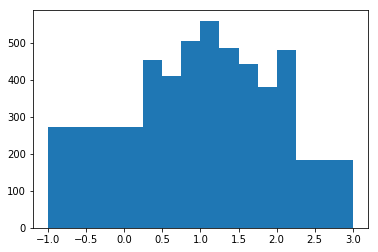

In [78]:
plt.hist(labels, bins=[-1, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 3])

In [80]:
len([l for l in labels if l <= -0.5 and l >= -1.0])

71

In [81]:
ecoli_df['value'].describe()

count   4508.00
mean       1.14
std        0.78
min       -1.64
25%        0.59
50%        1.14
75%        1.72
max        3.51
Name: value, dtype: float64

In [96]:
m = df.groupby(('sequence', 'bacterium'))['value'].mean()

In [112]:
def find_overlap(row):
    print(row)

In [163]:
convmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 42, 64)            7744      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 21, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 17, 64)            20544     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               51300     
__________

In [164]:
def count_r(cell):
    return cell.count('R')

def count_k(cell):
    return cell.count('K')

ecoli_df['sequence'].apply(count_r).head()

0    0
1    1
2    0
3    3
5    1
Name: sequence, dtype: int64

0           AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS
1                AAAAAAAIKMLMDLVNERIMALNKKAKK
2                            AAAKAALNAVLVGANA
3    AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC
5                                  AAGMGFFGAR
Name: sequence, dtype: object